# Introduction

In this notebook, we will explore how to build a machine learning model for classifying images using PyTorch, a widely used and acclaimed deep learning library. PyTorch has become a popular choice among researchers and machine learning practitioners because of its dynamic approach and flexibility for building and training complex models.

One of the distinct advantages of PyTorch is its focus on dynamic programming. Unlike some other deep learning libraries, PyTorch allows you to build and modify computational graphs on the fly, providing great flexibility for designing models and performing interactive experiments. In addition, PyTorch has a large user community and detailed documentation, making it easy to learn and troubleshoot.

Throughout this notebook, we will discover how to take full advantage of PyTorch's capabilities to build, train and evaluate our image classification model. From data preparation to implementing optimization techniques, we will explore the essential fundamentals so that you can develop your skills in the exciting field of machine learning with PyTorch. This notebook follows a basic machine learning workflow

### Index
1. Load and normalize the CIFAR10 training and test datasets
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data


### Data Loading




In [ ]:
#title Load Data Cifar10

import torch
import torchvision
import time
import random
import seaborn as sns

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load and transform data
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1024, shuffle=False)

# preload

train_data = [ sample for sample in trainloader ]
test_data  = [ sample for sample in testloader  ]

100%|██████████| 170498071/170498071 [00:03<00:00, 48376065.83it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Data Visualization

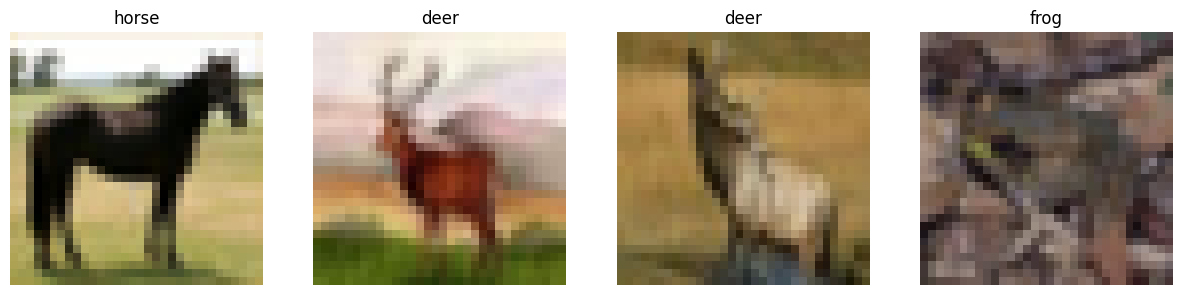

In [ ]:
# visualize data with labels

import matplotlib.pyplot as plt
import numpy as np

# get classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0)).astype(np.float32)
# get some random training images

dataiter = iter(trainloader)
images, labels = next(dataiter)

fig, axs = plt.subplots(1, 4, figsize=(15, 5))

for image, i in zip(images, range(4)):

    # show images
    image = imshow(image)
    axs[i].imshow(image)
    axs[i].set_title(classes[labels[i]])
    axs[i].axis('off')


##2. Convolutional Neural Network

The model consists of the following components:

Input Layer: Accepts 3-channel (RGB) images as input.

Convolutional Layers: The network starts with a convolutional layer followed by batch normalization. Then, a configurable number of additional convolutional layers are added, each followed by batch normalization and a ReLU activation function. These layers capture hierarchical features from the input images.

Max Pooling: After each convolutional layer, max pooling is performed to downsample the feature maps, reducing their spatial dimensions.

Flattening: The feature maps are flattened into a 1D vector to be processed by the fully connected layers.

Fully Connected Layers: A single fully connected layer is added, which takes the flattened feature vector as input. The output size of this layer is determined by the number of target classes (in this case, 10 classes). The fully connected layer is followed by a softmax activation function to obtain class probabilities.

In [ ]:
# Classification model ResNet18 based

import torch.nn as nn

class ClassificationNet(nn.Module):

    def __init__(self, features=16, num_layers=4, img_size=32):
        super(ClassificationNet, self).__init__()

        # define layers
        layers = []

        down_factor = 1

        # first layer
        layers.append(nn.Conv2d(3, features, kernel_size=3, stride=1, padding=1, bias=False))
        layers.append(nn.BatchNorm2d(features))

        # hidden layers
        for _ in range(num_layers):
            layers.append(nn.Conv2d(features, features, kernel_size=3, stride=1, padding=1, bias=False))
            layers.append(nn.BatchNorm2d(features))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            down_factor *= 2

        layers.append(nn.Flatten())

        final_size = int(img_size / down_factor)

        # output layer
        layers.append(nn.Linear(features * final_size * final_size, 10))
        layers.append(nn.Softmax(dim=1))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [ ]:
model = ClassificationNet()

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
class AverageMeter(object):
  '''A handy class from the PyTorch ImageNet tutorial'''
  def __init__(self):
    self.reset()

  def __str__(self):
    return f"{self.avg}"

  def reset(self):
    self.vals, self.avg, self.sum, self.count = [], 0, 0, 0

  def update(self, val, n=1):
    self.vals.append(val)
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count




In [ ]:
# top1 accuracy
def accuracy(output, target, topk=(1,)):
    '''Computes the accuracy over the k top predictions for the specified values of k'''
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()

        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))

        return res

In [ ]:

def validate(test_loader, model, criterion):
    model.eval()

    batch_time, data_time, losses, top1 = AverageMeter(), AverageMeter(), AverageMeter(), AverageMeter()

    end = time.time()

    for i, (image, label) in enumerate(test_loader):

        data_time.update(time.time() - end)

        image, label = image.to(device), label.to(device)

        output = model(image)
        loss = criterion(output, label)
        losses.update(loss.item(), image.size(0))

        # measure accuracy and record loss
        prec1 = accuracy(output.data, label, topk=(1,))[0].item()
        top1.update(prec1, image.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

    print(f'Test: \tTime {batch_time.vals[-1]:.3f} ({batch_time.avg:.3f})\t'
        f'Data {data_time.vals[-1]:.3f} ({data_time.avg:.3f})\t'
        f'Loss {losses.vals[-1]:.4f} ({losses.avg:.4f})\t'
        f'Accuracy {top1.vals[-1]:.3f} ({top1.avg:.3f})')

    return losses.avg, top1.avg

In [ ]:
def train(train_loader, model, criterion, optimizer, epoch, verbose=True):
    random.shuffle(train_loader)

    print('Starting training epoch {}'.format(epoch))
    model.train()
    scaler = torch.cuda.amp.GradScaler()

    batch_time, data_time, losses, top1 = AverageMeter(), AverageMeter(), AverageMeter(), AverageMeter()

    end = time.time()

    for i, (image, label) in enumerate(train_loader):
        optimizer.zero_grad()

        image, label = image.to(device), label.to(device)

        data_time.update(time.time() - end)

        with torch.cuda.amp.autocast(dtype=torch.float16):
          output = model(image)
          loss = criterion(output, label)

        losses.update(loss.item(), image.size(0))

        # measure accuracy and record loss
        prec1 = accuracy(output.data, label, topk=(1,))[0].item()

        top1.update(prec1, image.size(0))


        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 50 == 0 and verbose:

            print(f'Epoch: [{epoch}][{i}/{len(train_loader)}]\t'
                f'Time {batch_time.vals[-1]:.3f} ({batch_time.avg:.3f})\t'
                f'Data {data_time.vals[-1]:.3f} ({data_time.avg:.3f})\t'
                f'Loss {losses.vals[-1]:.4f} ({losses.avg:.4f})\t'
                f'Accuracy {top1.vals[-1]:.3f} ({top1.avg:.3f})')


    return losses.vals, top1.vals

In [ ]:
# Move model and loss function to GPU

criterion = criterion.to(device)
model = model.to(device)

In [ ]:
# train model for 1000 epochs

epochs = 2
history = {
    'loss': [],
    'acc': [],
    'val_loss': [],
    'val_acc': [],
    'name': ""
}

for epoch in range(epochs):

    losses, acc = train(train_data, model, criterion, optimizer, epoch)

    with torch.no_grad():
        val_loss, val_acc = validate(test_data, model, criterion)

    history['loss'].extend(losses)
    history['acc'].extend(acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)


history['name'] = model.__class__.__name__

Starting training epoch 0
Epoch: [0][0/98]	Time 7.486 (7.486)	Data 0.003 (0.003)	Loss 2.3046 (2.3046)	Accuracy 8.008 (8.008)
Epoch: [0][50/98]	Time 0.014 (0.162)	Data 0.002 (0.002)	Loss 2.1578 (2.2151)	Accuracy 31.445 (26.088)
Test: 	Time 0.015 (0.019)	Data 0.000 (0.000)	Loss 2.0295 (2.0357)	Accuracy 47.449 (46.810)
Starting training epoch 1
Epoch: [1][0/98]	Time 0.016 (0.016)	Data 0.002 (0.002)	Loss 2.0354 (2.0354)	Accuracy 48.242 (48.242)
Epoch: [1][50/98]	Time 0.013 (0.013)	Data 0.002 (0.002)	Loss 1.9744 (2.0074)	Accuracy 52.344 (48.732)
Test: 	Time 0.013 (0.018)	Data 0.000 (0.000)	Loss 1.9468 (1.9491)	Accuracy 54.209 (54.680)


In [ ]:
# this is just for test
# ignore this cell

epochs = 2
history_2 = {
    'loss': [],
    'acc': [],
    'val_loss': [],
    'val_acc': [],
    'name': ""
}

for epoch in range(epochs):

    losses, acc  = train(train_data, model, criterion, optimizer, epoch)

    with torch.no_grad():
        val_loss, val_acc = validate(test_data, model, criterion)

    history_2['loss'].extend(losses)
    history_2['acc'].extend(acc)
    history_2['val_loss'].append(val_loss)
    history_2['val_acc'].append(val_acc)

history_2['name'] = model.__class__.__name__

Starting training epoch 0
Epoch: [0][0/98]	Time 0.019 (0.019)	Data 0.002 (0.002)	Loss 1.9484 (1.9484)	Accuracy 52.930 (52.930)
Epoch: [0][50/98]	Time 0.013 (0.013)	Data 0.002 (0.002)	Loss 1.8678 (1.9122)	Accuracy 63.086 (58.105)
Test: 	Time 0.013 (0.018)	Data 0.000 (0.000)	Loss 1.8883 (1.8797)	Accuracy 59.821 (60.680)
Starting training epoch 1
Epoch: [1][0/98]	Time 0.015 (0.015)	Data 0.002 (0.002)	Loss 1.8713 (1.8713)	Accuracy 61.914 (61.914)
Epoch: [1][50/98]	Time 0.013 (0.013)	Data 0.002 (0.002)	Loss 1.8437 (1.8648)	Accuracy 63.867 (62.056)
Test: 	Time 0.013 (0.019)	Data 0.000 (0.000)	Loss 1.8648 (1.8538)	Accuracy 61.480 (62.700)


In [ ]:
def acc_barplot(history):
    """
    this function plots the training and testing history for n models in a barplot

    Parameters:
    -----------
    history: numpy array
        list of training history for n models, each model is a dictionary with keys 'loss', 'acc', 'val_loss', 'val_acc', 'name'
        each model must have the same number of epochs and metrics
    """

    models = [ f'{e["name"]}' for i, e in enumerate(history) ]
    #check repeated name values
    models = [ models[i] + '_' if models[i] in models[:i] else models[i] for i in range(len(models)) ]

    accs = [ model['acc'][-1] for model in history ]
    val_accs = [ model['val_acc'][-1] for model in history ]
    acc = accs + val_accs

    hue_labels = ['train'] * len(accs) + ['test'] * len(val_accs)

    sns.set(style="whitegrid")
    sns.barplot(x=models * 2, y=acc, hue=hue_labels)

    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.title('Accuracy of Models (Train vs Test)')

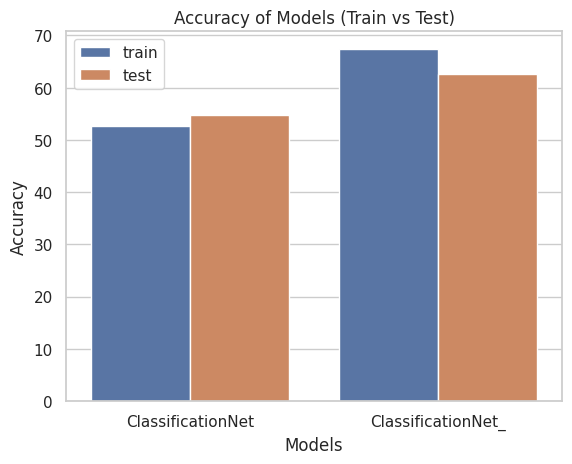

In [ ]:
acc_barplot(np.array([history,history_2]))

In [ ]:
def batch_lineplot(history):
    """
    This function plots the training and testing history for n models

    Parameters:
    ----------
    history: numpy array
        list of training history for n models, each model is a dictionary with keys 'loss', 'acc', 'val_loss', 'val_acc', 'name'
        each model must have the same number of epochs and metrics

    """

    accs = [ model['acc'] for model in history ]

    val_accs = [ model['val_acc'] for model in history ]

    sns.set(style="whitegrid")

    plt.figure(figsize=(10, 6))
    for i,acc in enumerate(accs):
        sns.lineplot(x=range(len(acc)), y=acc, label=f'{history[i]["name"][0]}')

    plt.gca().set_prop_cycle(None) # restar color cycle

    for i, val_acc in enumerate(val_accs):
        sns.lineplot(x=range( len(accs[0])//(len(val_acc)), len(accs[0])+1, len(accs[0])//(len(val_acc))), y=val_acc, label=f'{history[i]["name"][0]} (test)'
                     , marker='o', markersize=7, linestyle='--')

    plt.xlabel('Batch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy of Models (Train vs Test)')

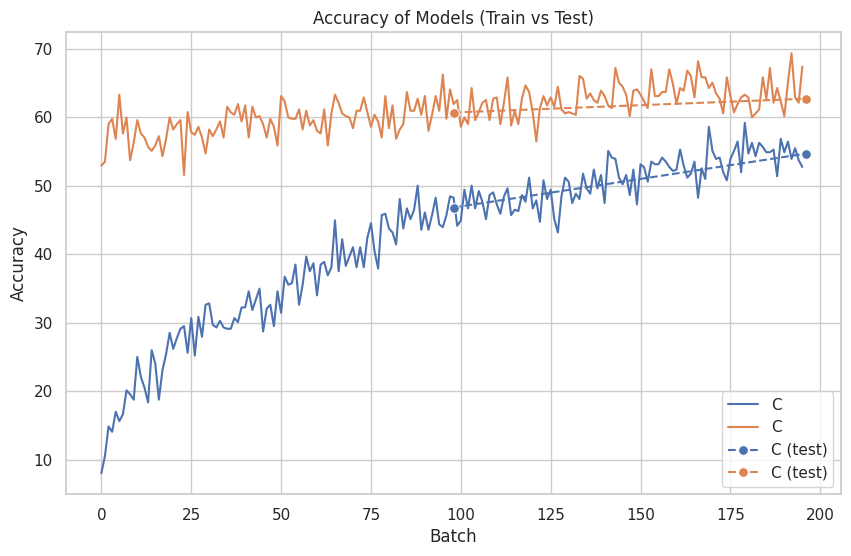

In [ ]:
batch_lineplot(np.array([history,history_2]))

## hyperparameter tuning

### batch tuning

In [ ]:
# train classificationnet with differents batch sizes

batch_sizes = [ 32, 64, 128, 256, 512, 1024 ]

historys = []

for batch_size in batch_sizes:

        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
        testloader = torch.utils.data.DataLoader(testset, batch_size=1024, shuffle=False)

        train_data = [ sample for sample in trainloader ]
        test_data  = [ sample for sample in testloader  ]

        model = ClassificationNet()
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        criterion = criterion.to(device)
        model = model.to(device)

        epochs = 3
        history = {
            'loss': [],
            'acc': [],
            'val_loss': [],
            'val_acc': [],
            'name': ""
        }

        for epoch in range(epochs):

            losses, acc  = train(train_data, model, criterion, optimizer, epoch, verbose=False)

            with torch.no_grad():
                val_loss, val_acc = validate(test_data, model, criterion)

            history['loss'].extend(losses)
            history['acc'].extend(acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)

        history['name'] = str(batch_size)
        historys.append(history)


Starting training epoch 0
Test: 	Time 0.016 (0.022)	Data 0.000 (0.000)	Loss 1.9208 (1.9055)	Accuracy 53.571 (56.480)
Starting training epoch 1
Test: 	Time 0.013 (0.020)	Data 0.000 (0.000)	Loss 1.8536 (1.8475)	Accuracy 61.224 (62.160)
Starting training epoch 2
Test: 	Time 0.014 (0.022)	Data 0.000 (0.000)	Loss 1.8339 (1.8328)	Accuracy 62.372 (63.090)
Starting training epoch 0
Test: 	Time 0.014 (0.018)	Data 0.000 (0.000)	Loss 1.9164 (1.9269)	Accuracy 57.143 (54.610)
Starting training epoch 1
Test: 	Time 0.013 (0.018)	Data 0.000 (0.000)	Loss 1.8747 (1.8675)	Accuracy 59.694 (60.630)
Starting training epoch 2
Test: 	Time 0.013 (0.018)	Data 0.000 (0.000)	Loss 1.8394 (1.8336)	Accuracy 63.393 (63.400)
Starting training epoch 0
Test: 	Time 0.013 (0.019)	Data 0.000 (0.000)	Loss 1.9383 (1.9366)	Accuracy 54.974 (54.570)
Starting training epoch 1
Test: 	Time 0.013 (0.018)	Data 0.000 (0.000)	Loss 1.8666 (1.8645)	Accuracy 61.097 (61.140)
Starting training epoch 2
Test: 	Time 0.013 (0.018)	Data 0.000 (

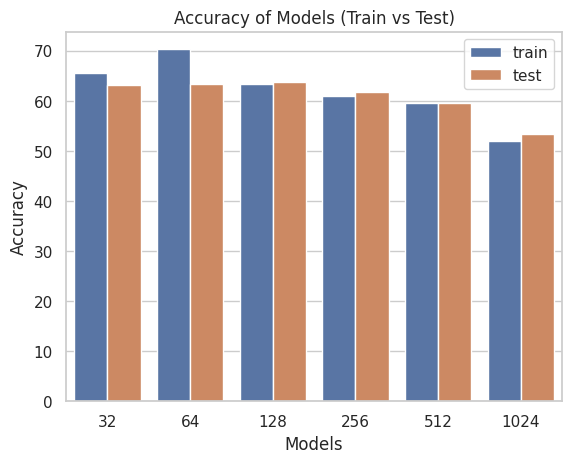

In [ ]:
acc_barplot(np.array(historys))

### learning rate tuning

In [ ]:
lrs = [ 0.0001, 0.001, 0.01, 0.1, 1 ]

historys = []

trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=1024, shuffle=False)
train_data = [ sample for sample in trainloader ]
test_data  = [ sample for sample in testloader  ]

for lr in lrs:

            model = ClassificationNet()
            criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)

            criterion = criterion.to(device)
            model = model.to(device)

            epochs = 3
            history = {
                'loss': [],
                'acc': [],
                'val_loss': [],
                'val_acc': [],
                'name': ""
            }

            for epoch in range(epochs):

                losses, acc  = train(train_data, model, criterion, optimizer, epoch, verbose=False)

                with torch.no_grad():
                    val_loss, val_acc = validate(test_data, model, criterion)

                history['loss'].extend(losses)
                history['acc'].extend(acc)
                history['val_loss'].append(val_loss)
                history['val_acc'].append(val_acc)

            history['name'] = str(lr)
            historys.append(history)

Starting training epoch 0
Test: 	Time 0.014 (0.018)	Data 0.000 (0.000)	Loss 2.2387 (2.2435)	Accuracy 22.321 (22.260)
Starting training epoch 1
Test: 	Time 0.014 (0.018)	Data 0.000 (0.000)	Loss 2.1942 (2.1988)	Accuracy 27.806 (29.770)
Starting training epoch 2
Test: 	Time 0.014 (0.018)	Data 0.000 (0.000)	Loss 2.1509 (2.1524)	Accuracy 34.056 (35.990)
Starting training epoch 0
Test: 	Time 0.014 (0.018)	Data 0.000 (0.000)	Loss 2.0392 (2.0428)	Accuracy 46.301 (45.920)
Starting training epoch 1
Test: 	Time 0.014 (0.018)	Data 0.000 (0.000)	Loss 1.9734 (1.9699)	Accuracy 51.020 (51.260)
Starting training epoch 2
Test: 	Time 0.014 (0.018)	Data 0.000 (0.000)	Loss 1.9273 (1.9259)	Accuracy 55.230 (55.320)
Starting training epoch 0
Test: 	Time 0.014 (0.018)	Data 0.000 (0.000)	Loss 1.9359 (1.9259)	Accuracy 52.296 (53.970)
Starting training epoch 1
Test: 	Time 0.014 (0.018)	Data 0.000 (0.000)	Loss 1.9117 (1.9076)	Accuracy 55.230 (55.220)
Starting training epoch 2
Test: 	Time 0.014 (0.018)	Data 0.000 (

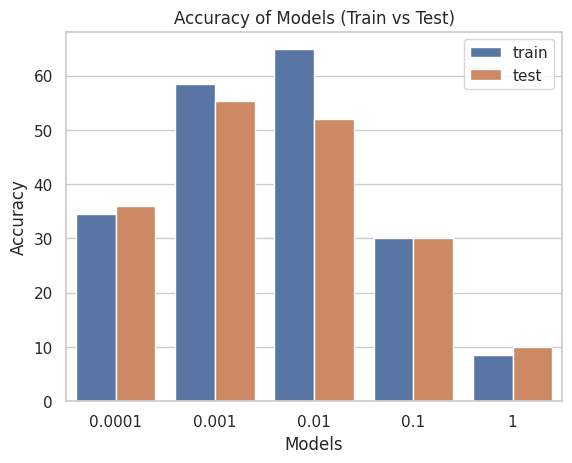

In [ ]:
acc_barplot(np.array(historys))